In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append("..")

from helper import load_countries, join_countries

In [28]:
DATA_PATH = "../../data/"

# External datasets

We first need to load the datasets we will use to compute the correlations.

The preprocessed countries contains the mapping between the different code standards used by each datasets

In [29]:
countries = pd.read_csv(DATA_PATH + "preprocessed_countries.csv")
countries.Country = countries.Country.astype(str).str.strip()
countries.head(5)

,Country,Region,FIPS,ISO2,ISO3
0,Afghanistan,Asia,AF,AF,AFG
1,Albania,Europe,AL,AL,ALB
2,Algeria,Africa,AG,DZ,DZA
3,American Samoa,Oceania,AQ,AS,ASM
4,Andorra,Europe,AN,AD,AND


### Human development index ([source](http://hdr.undp.org/en/content/human-development-index-hdi))

The Human Development Index (HDI) is a statistic composite index of life expectancy, education, and per capita income indicators, which are used to rank countries into four tiers of human development.

In [30]:
hdi = pd.read_csv(DATA_PATH + "external_datasets/human_development_index_2017.csv")
hdi.head(5)

,HDI Rank,Country,ISO3,2015,2016,2017
0,168,Afghanistan,AFG,0.493,0.494,0.498
1,68,Albania,ALB,0.776,0.782,0.785
2,85,Algeria,DZA,0.749,0.753,0.754
3,35,Andorra,AND,0.854,0.856,0.858
4,147,Angola,AGO,0.572,0.577,0.581


In [31]:
hdi = hdi.set_index("ISO3")[["2017"]]
hdi.rename(columns={"2017":"hdi_2017"}, inplace=True)
hdi.head(5)

,hdi_2017
ISO3,
AFG,0.498
ALB,0.785
DZA,0.754
AND,0.858
AGO,0.581


### Environmental performance index ([source](https://epi.envirocenter.yale.edu/epi-downloads))

The Environmental Performance Index (EPI) is a method of quantifying and numerically marking the environmental performance of a state's policies. 

In [32]:
epi = pd.read_csv(DATA_PATH + "external_datasets/epi2018countrysnapshotv01.csv")
epi.head(5)

,code,iso,country,Pop,PopGrowthRate,PopDensity,GDP,LandArea,GDPpc,SDGI,EPI2018Score,EPI2018Rank
0,4,AFG,Afghanistan,34.656032,2.689163,53.083405,60.287050,652860.0,1739.583177,46.8,37.74,168
1,8,ALB,Albania,2.876101,-0.159880,104.967190,32.669916,27400.0,11359.099160,68.9,65.46,40
2,12,DZA,Algeria,40.606052,1.825463,17.048895,565.284000,2381741.0,13921.176080,68.8,57.18,88
3,24,AGO,Angola,28.813463,3.367572,23.111786,172.438000,1246700.0,5984.632947,50.2,37.44,170
4,28,ATG,Antigua and Barbuda,0.100963,1.035422,229.461364,2.121537,440.0,21013.017630,NaN,59.18,76


In [33]:
epi = epi[["iso", "country", "GDPpc", "EPI2018Score"]]
epi = epi.set_index("iso")
epi.head(5)

,country,GDPpc,EPI2018Score
iso,,,
AFG,Afghanistan,1739.583177,37.74
ALB,Albania,11359.099160,65.46
DZA,Algeria,13921.176080,57.18
AGO,Angola,5984.632947,37.44
ATG,Antigua and Barbuda,21013.017630,59.18


In [34]:
external_data = hdi.join(epi).join(countries.set_index("ISO3")[["ISO2", "Region"]])
external_data.head(5)

,hdi_2017,country,GDPpc,EPI2018Score,ISO2,Region
ISO3,,,,,,
AFG,0.498,Afghanistan,1739.583177,37.74,AF,Asia
AGO,0.581,Angola,5984.632947,37.44,AO,Africa
ALB,0.785,Albania,11359.099160,65.46,AL,Europe
AND,0.858,NaN,NaN,NaN,AD,Europe
ARE,0.863,United Arab Emirates,67133.014840,58.90,AE,Asia


# Mentions ratios

Here we load the mentions ratios with the outliers removed (for details, see [mentions_counts_by_domain_locations.ipynb](../mentions_count/mentions_counts_by_domain_locations.ipynb)) and then we compute the mean ratio for each countries.

In [45]:
MENTIONS_COUNTS_FILE = DATA_PATH + "mentions_counts_by_state_and_day_filtered_5themes.csv.NO_OULIERS.csv"

In [46]:
mentions_ratios = pd.read_csv(MENTIONS_COUNTS_FILE, index_col=0)
mentions_ratios.sample(10)

,ISO,GLOBAL_COUNT,ENV_COUNT,Country,Region,DATE,Ratio
33596,CZ,420,1.0,Czechia,Europe,2017-07-05,0.002381
135785,TZ,533,39.0,"Tanzania, United Republic of",Africa,2015-12-22,0.073171
132110,TN,162,4.0,Tunisia,Africa,2016-11-12,0.024691
67510,IT,5948,26.0,Italy,Europe,2016-07-03,0.004371
136336,TZ,370,7.0,"Tanzania, United Republic of",Africa,2016-11-10,0.018919
43434,FI,300,1.0,Finland,Europe,2017-06-19,0.003333
112218,PT,245,2.0,Portugal,Europe,2017-09-09,0.008163
2460,AL,220,18.0,Albania,Europe,2017-06-28,0.081818
7361,AU,16718,652.0,Australia,Oceania,2017-10-16,0.039000
84306,MA,178,3.0,Morocco,Africa,2015-02-28,0.016854


In [47]:
means = mentions_ratios.groupby("ISO").mean()
means = means.assign(MEAN=means.ENV_COUNT/means.GLOBAL_COUNT)[["MEAN"]]
ratios = means
#medians = mentions_ratios.groupby("ISO").median()
#medians = medians.assign(MEDIAN=medians.ENV_COUNT/medians.GLOBAL_COUNT)[["MEDIAN"]]
#ratios = means.join(medians)

In [48]:
ratios.sample(10)

,MEAN
ISO,
MQ,0.542203
US,0.035341
GR,0.021962
AU,0.038321
AE,0.037336
LT,0.027309
IL,0.010201
SA,0.050039
KE,0.028531


# Join to external datasets

In [49]:
joined = ratios.join(external_data.set_index("ISO2", drop=True), how="left")
joined = joined[joined.Region != "Oceania"]
joined.head(5)

,MEAN,hdi_2017,country,GDPpc,EPI2018Score,Region
AD,0.038889,0.858,NaN,NaN,NaN,Europe
AE,0.037336,0.863,United Arab Emirates,67133.014840,58.90,Asia
AF,0.049024,0.498,Afghanistan,1739.583177,37.74,Asia
AG,0.285182,0.780,Antigua and Barbuda,21013.017630,59.18,Americas
AI,0.659288,NaN,NaN,NaN,NaN,NaN


In [50]:
joined.describe()

,MEAN,hdi_2017,GDPpc,EPI2018Score
count,216.000000,181.000000,172.000000,172.000000
mean,0.085147,0.712541,18297.231215,56.714826
std,0.147496,0.155464,19356.563508,13.174585
min,0.007947,0.354000,647.880445,27.430000
25%,0.026083,0.589000,4284.816516,46.247500
50%,0.037144,0.747000,12657.471790,57.060000
75%,0.063293,0.838000,25021.809900,64.987500
max,0.938528,0.953000,118207.069500,87.420000


In [51]:
def lmplot(data, x, y="MEAN", title="", world=False, figsize=(12,6)):
    plt.figure(figsize=figsize)
    plt.suptitle(title)
    sns.lmplot(x, y, data=data, col="Region" if not world else None, robust=True)

<Figure size 864x432 with 0 Axes>

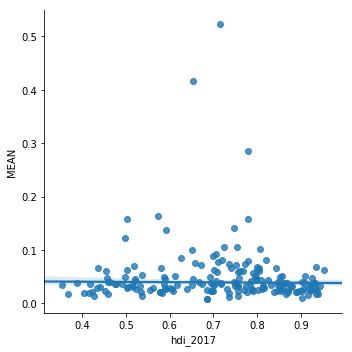

<Figure size 864x432 with 0 Axes>

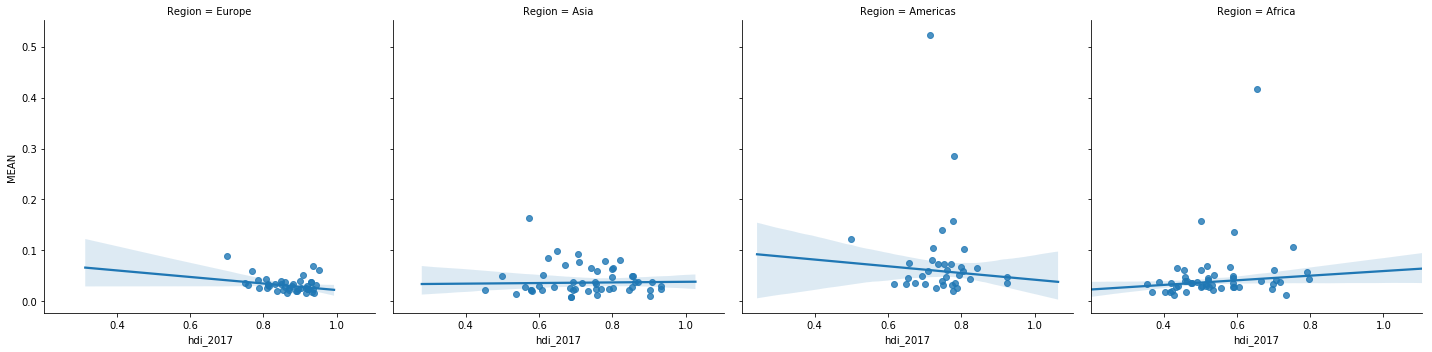

In [52]:
lmplot(joined, "hdi_2017", "MEAN", "Human development index vs ratio mean", world=True)
lmplot(joined, "hdi_2017", "MEAN", "Human development index vs ratio mean", world=False)

<Figure size 864x432 with 0 Axes>

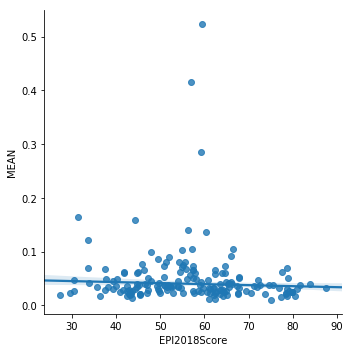

<Figure size 864x432 with 0 Axes>

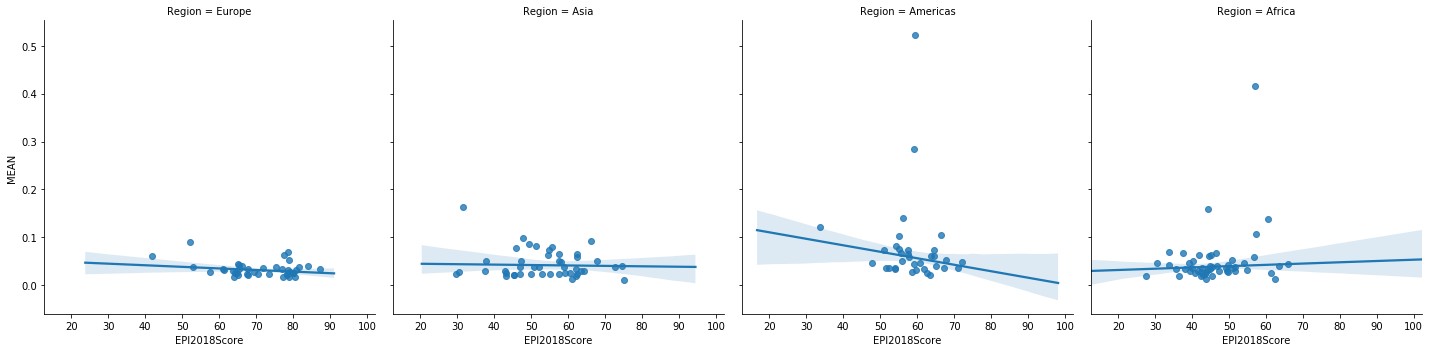

In [53]:
lmplot(joined, "EPI2018Score", "MEAN", "Environmental performance index vs ratio mean", world=True)
lmplot(joined, "EPI2018Score", "MEAN", "Environmental performance index vs ratio mean", world=False)

<Figure size 864x432 with 0 Axes>

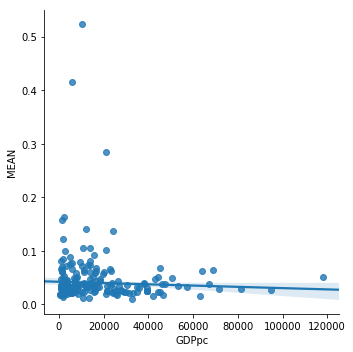

<Figure size 864x432 with 0 Axes>

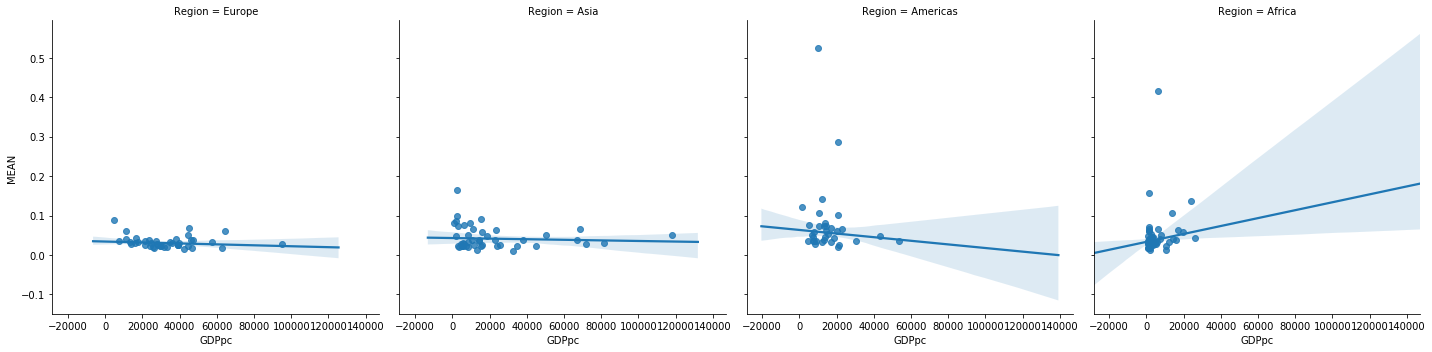

In [54]:
lmplot(joined, "GDPpc", "MEAN", "GDP per capita vs ratio mean", world=True)
lmplot(joined, "GDPpc", "MEAN", "GDP per capita vs ratio mean", world=False)